In [1]:
import sys
print(sys.executable)
!conda info | grep 'active env'

/sc/arion/work/massen06/.conda/envs/qc/bin/python3.8
     active environment : qc
    active env location : /sc/arion/work/massen06/.conda/envs/qc


In [2]:
import os
import copy
import pge
import anndata as ad
import scanpy as sc
import pandas as pd
import pegasus as pg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packag

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


# Mouse Living Brain Quality Control
Nicolas Masse, Donghoon Lee  
July 2023

### Adding directory where metadata spreadsheet is stored, location to save the AnnData, and location of the gene info

In [52]:
metadata_dir = "/sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/metadata"
base_dir = "/sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams"
save_dir = "/sc/arion/work/massen06/living_brain/anndata"
gene_info_fn = "/hpc/users/massen06/MM_GRCm39_full.txt" 
mouse_mitocarta_fn = "MouseMitoCarta3.0.csv" 

## Extract metadata from Living_brain_snRNA_template.xlsx


In [50]:
metadata_fn = os.path.join(metadata_dir, "Living_brain_snRNA_template.xlsx")
metadata = pd.read_excel(metadata_fn, sheet_name="Mouse_Master Libraries")

In [51]:
def extract_donor_information(data):
    """Extract donor name, PMI and living status"""
    
    donor_info = {
        "unique_id": [],
        "donor" : [],
        "pmi": [],
        "living": [],
    }

    for d in data.values:
        
        donor_info["unique_id"].append(d)
        
        # get donor name
        i0 = d.find("_")
        donor_info["donor"].append(d[: i0])
        
        # get PMI
        time = int("".join([s for s in d[i0 :] if s.isdigit()]))
        if "hr" in d[i0 :]:
            time *= 60
        donor_info["pmi"].append(time)
        
        if "PM" in d or "Post" in d or time > 0:
            donor_info["living"].append(False)
        else:
            donor_info["living"].append(True)
        
    return donor_info

In [6]:
for k in metadata.keys():
    
    column_name = metadata[k].iloc[0]

    if column_name == "unique sample ID":
        donor_info = extract_donor_information(metadata[k].iloc[1 :])
        
    elif column_name == "Step 2 date":
        dates = metadata[k].iloc[1 :]
        dates = [d.strftime("%m%d%Y") for d in dates]
        donor_info["stage_2_date"] = dates
        
    elif column_name == "cDNA Amp cycle #s":
        cycles = metadata[k].iloc[1 :]
        cycles = [int(c) for c in cycles]
        donor_info["cdna_amp_cycle"] = cycles
        
    elif column_name == "input (ng)":
        inputs = metadata[k].iloc[1 :]
        inputs = [round(float(i), 1) for i in inputs]
        donor_info["input_ng"] = inputs
        
    elif column_name == "Indexing PCR cycle #":
        cycle = metadata[k].iloc[1 :]
        cycle = [int(c) for c in cycle]
        donor_info["pcr_cycle"] = cycle
        
donor_info = pd.DataFrame(data = donor_info)

print(donor_info)  

              unique_id donor  pmi  living stage_2_date  cdna_amp_cycle  \
0   WTA_0min_Living_PFC   WTA    0    True     06022023              11   
1           WTA_0min_PM   WTA    0   False     06022023              11   
2              912_0min   912    0    True     06022023              11   
3              912_5min   912    5   False     06022023              11   
4              WTF_0min   WTF    0    True     06022023              11   
5               WTF_1hr   WTF   60   False     06022023              11   
6   WTB_0min_Living_PFC   WTB    0    True     06062023              12   
7           WTB_0min_PM   WTB    0   False     06062023              12   
8              913_0min   913    0    True     06062023              12   
9              913_5min   913    5   False     06062023              12   
10      WTE_0min_Living   WTE    0    True     06062023              12   
11         WTE_6hr_Post   WTE  360   False     06062023              12   
12      WTC_0min_Living  

### Load gene info from Biomart

In [7]:
gene_info = pd.read_csv(gene_info_fn, sep='\t')
gene_info.drop_duplicates(subset = "Gene name", inplace=True)
gene_info.reset_index(inplace=True)

/tmp/ipykernel_4267/2319207433.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_info = pd.read_csv(gene_info_fn, sep='\t')


In [8]:
def link_gene_info(adata, gene_info, verbose=False):
    
    adata.var = adata.var.merge(gene_info, left_on="gene_ids", right_on='Gene stable ID', how="outer")

    good_genes_idx = [i for i, name in enumerate(adata.var["Gene name"].values) if isinstance(name, str)]
       
    new_adata = ad.AnnData(adata.X[:, good_genes_idx])
    new_adata.obs = adata.obs
    new_adata.var["gene_name"] = [v for n, v in enumerate(adata.var["Gene name"].values) if n in good_genes_idx]
    new_adata.var["gene_type"] = [v for n, v in enumerate(adata.var["Gene type"].values)  if n in good_genes_idx]
    new_adata.var["gene_id"] = [v for n, v in enumerate(adata.var["Gene stable ID"].values)  if n in good_genes_idx]
    
    print(f"Variables added. Number of genes remaining: {new_adata.X.shape[1]}")
    
    return new_adata

## Create AnnData from all samples

In [10]:
target_dirs = [fn for fn in os.listdir(base_dir) if "Solo.out" in fn]
print(f"Number of target directories found: {len(target_dirs)}")

Number of target directories found: 18


In [11]:
adata = None

for n, t in enumerate(target_dirs):

    # Load 10x data
    data_path = os.path.join(base_dir, t, "GeneFull", "filtered")
    print(f"Creating anndata from {data_path}")
    adata_temp = sc.read_10x_mtx(data_path)
    
    # Find the matching donor ID
    idx = t.find("Solo")
    sample_id = t[3: idx - 1] # index starts at 3 to remove prefix "LB_"
    donor_idx = [i for i, donor_id in enumerate(donor_info.unique_id) if sample_id in donor_id]
    assert len(donor_idx) <= 1, "Multiple matches for sample ID"
    
    for k, v in donor_info.iloc[donor_idx[0]].items():
        adata_temp.obs[k] = v
    if adata is None:
        adata = copy.deepcopy(adata_temp)
    else:        

        adata = ad.concat([adata, adata_temp], axis=0, merge="same")   

for k, v in adata_temp.var.items():
    adata.var[k] = v

adata = link_gene_info(adata, gene_info)

anndata_fn = os.path.join(save_dir, "mouse_living_brain.h5ad")
adata.write(anndata_fn)
print(f"Saved {anndata_fn}")

Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_912_0min_Solo.out/GeneFull/filtered
Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTE_0min_Living_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTF_0min_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTD_6hr_Post_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTD_0min_Living_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTG_0min_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTF_1hr_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTC_0min_PM_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_913_5min_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTE_6hr_Post_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_912_5min_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTG_1hr_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTB_0min_PM_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTA_0min_PM_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTA_0min_Living_PFC_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTB_0min_Living_PFC_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_913_0min_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating anndata from /sc/arion/projects/CommonMind/single-cell-neurogenomics/LIVING_BRAIN/pre_processed_files/STARsolo_bams/LB_WTC_0min_Living_Solo.out/GeneFull/filtered


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Variables added. Number of genes remaining: 56481
Saved /sc/arion/work/massen06/living_brain/anndata/mouse_living_brain.h5ad


## Quality control using Pegasus

In [12]:
data = pg.read_input(anndata_fn, file_type='h5ad', genome='GRCm39', modality='rna')

2023-07-20 10:42:28,680 - pegasusio.readwrite - INFO - h5ad file '/sc/arion/work/massen06/living_brain/anndata/mouse_living_brain.h5ad' is loaded.
2023-07-20 10:42:28,681 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.70s.


/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Identify robust genes and remove genes with low expression

In [13]:
### identify robust genes
pg.identify_robust_genes(data, percent_cells=0.05)

### remove features that are not robust (expressed at least 0.05% of cells) from downstream analysis
data._inplace_subset_var(data.var['robust'])
data

2023-07-20 10:42:30,272 - pegasus.tools.preprocessing - INFO - After filtration, 37660/56481 genes are kept. Among 37660 genes, 24058 genes are robust.
2023-07-20 10:42:30,272 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 1.59s.


MultimodalData object with 1 UnimodalData: 'GRCm39-rna'
    It currently binds to UnimodalData object GRCm39-rna

UnimodalData object with n_obs x n_vars = 78565 x 24058
    UID: GRCm39-rna; Genome: GRCm39; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'unique_id', 'donor', 'pmi', 'living', 'stage_2_date', 'cdna_amp_cycle', 'input_ng', 'pcr_cycle'
    var: 'gene_name', 'gene_type', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features'
    uns: 'genome', 'modality', 'uid'

### Add gene descriptions

In [68]:
### add ribosomal genes
data.var['ribosomal'] = [x.startswith("RP") for x in data.var.gene_name]
print(np.mean(data.var['ribosomal']))

### add mitochondrial genes
data.var['mitochondrial'] = [x.startswith("MT-") for x in data.var.gene_name]

### add protein_coding genes
data.var['protein_coding'] = [x=='protein_coding' for x in data.var.gene_type]

# TODO: find mouse equivalent
### define mitocarta_genes
mitocarta = pd.read_csv(mouse_mitocarta_fn)
data.var['mitocarta_genes'] = [True if x in list(mitocarta.Symbol) else False for x in data.var.gene_name]

### define robust_protein_coding genes (exclude ribosomal (RPL,RPS), mitochondrial, or mitocarta genes
data.var['robust_protein_coding'] = data.var['robust'] & data.var['protein_coding']
data.var.loc[data.var.ribosomal, 'robust_protein_coding'] = False
data.var.loc[data.var.mitochondrial, 'robust_protein_coding'] = False
data.var.loc[data.var.mitocarta_genes, 'robust_protein_coding'] = False

### show
data.var[data.var['robust_protein_coding']]

0.0
0.04447585002909635


,gene_name,gene_type,gene_id,n_cells,percent_cells,robust,highly_variable_features,ribosomal,mitochondrial,protein_coding,robust_protein_coding,mitocarta_genes
featurekey,,,,,,,,,,,,
18,Pcmtd1,protein_coding,ENSMUSG00000051285,30436,38.739897,True,True,False,False,True,True,False
32,Cdh7,protein_coding,ENSMUSG00000026312,12781,16.268058,True,True,False,False,True,True,False
36,Exo1,protein_coding,ENSMUSG00000039748,268,0.341119,True,True,False,False,True,True,False
40,Uxs1,protein_coding,ENSMUSG00000057363,22476,28.608159,True,True,False,False,True,True,False
41,Cdh19,protein_coding,ENSMUSG00000047216,9560,12.168268,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
56424,Smndc1,protein_coding,ENSMUSG00000025024,5088,6.476166,True,True,False,False,True,True,False
56428,Papss2,protein_coding,ENSMUSG00000024899,2632,3.350092,True,True,False,False,True,True,False
56435,Pten,protein_coding,ENSMUSG00000013663,38182,48.599249,True,True,False,False,True,True,False


## Determine the upper and lower ranges of genes per cell, and number of cells with expression for each gene

In [69]:
pg.qc_metrics(data)

In [70]:
### nUMI and nGene QCs
n_genes_lower, n_genes_upper = pge.qc_boundary(data.obs.n_genes, k=3)
n_counts_lower, n_counts_upper = pge.qc_boundary(data.obs.n_counts, k=3)

print('genes lower: %d upper: %d' % (n_genes_lower, n_genes_upper))
print('UMIs lower: %d upper: %d' % (n_counts_lower, n_counts_upper))

n_genes_upper = 15000
n_counts_upper = 200000

print('genes lower: %d upper: %d' % (n_genes_lower, n_genes_upper))
print('UMIs lower: %d upper: %d' % (n_counts_lower, n_counts_upper))

genes lower: 391 upper: 7011
UMIs lower: 438 upper: 27074
genes lower: 391 upper: 15000
UMIs lower: 438 upper: 200000


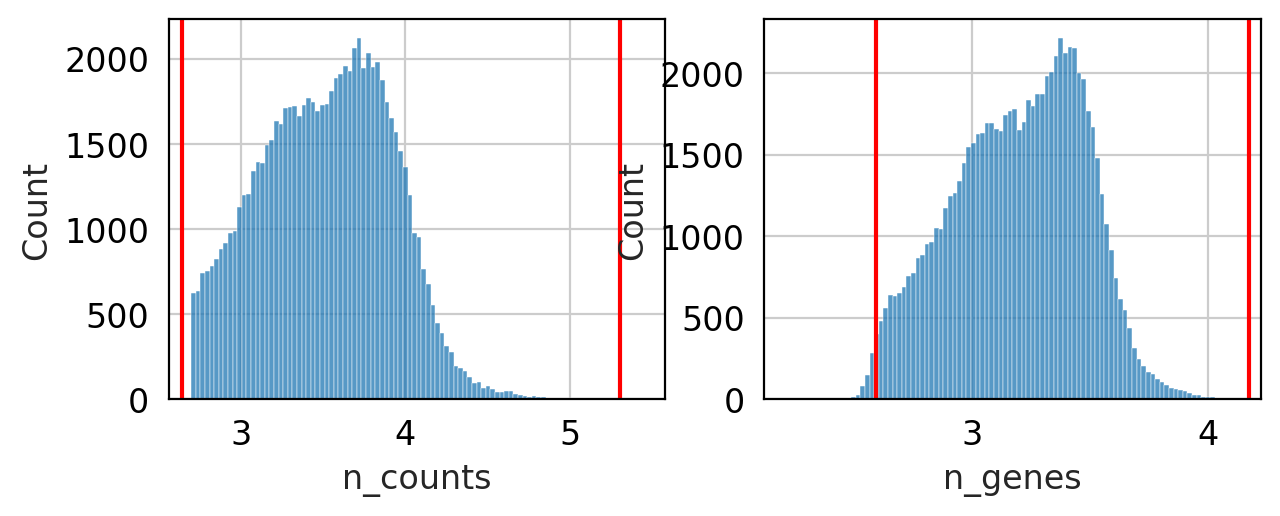

In [71]:
f, ax = plt.subplots(1, 2, figsize=(7,2.5))

# Library size (millions) VS. Number of cells
sns.histplot(np.log10(data.obs.n_counts), ax=ax[0])
ax[0].axvline(np.log10(n_counts_lower), color='red')
ax[0].axvline(np.log10(n_counts_upper), color='red')

# number of genes per cells
sns.histplot(np.log10(data.obs.n_genes), ax=ax[1])
ax[1].axvline(np.log10(n_genes_lower), color='red')
ax[1].axvline(np.log10(n_genes_upper), color='red')

plt.show()

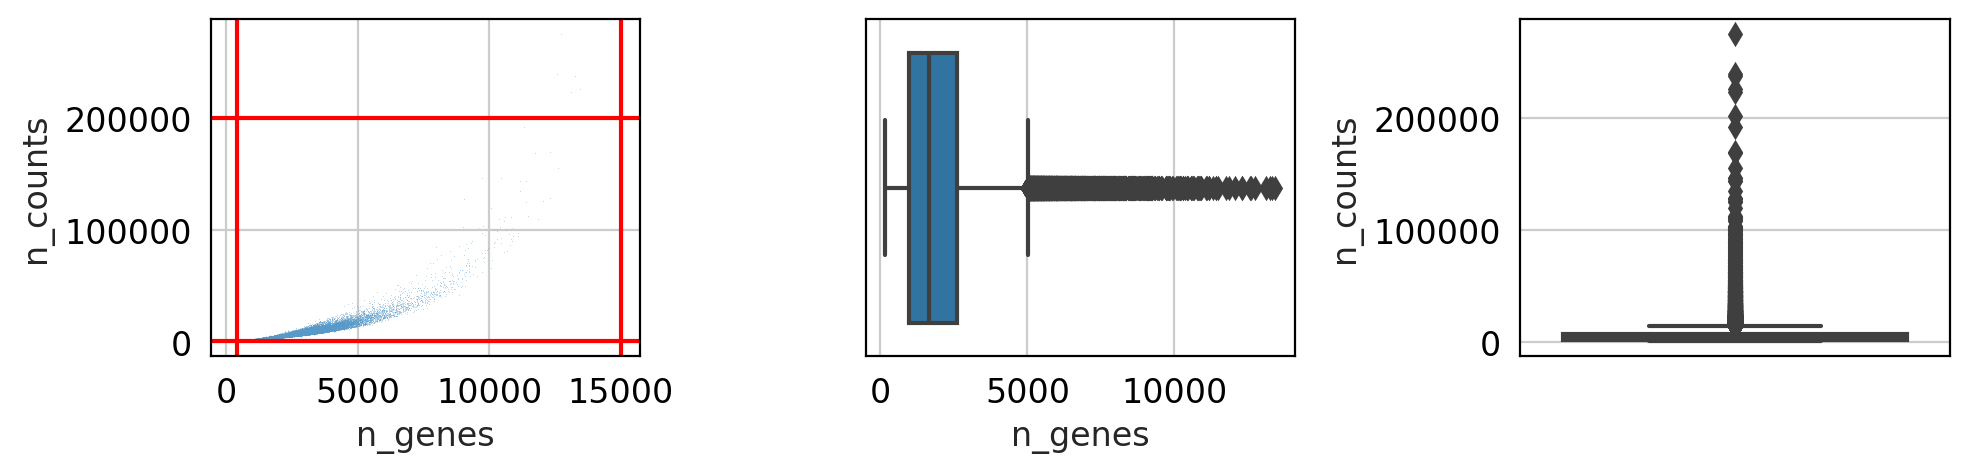

In [72]:
f, ax = plt.subplots(1, 3, figsize=(10,2.5))
sns.scatterplot(x=data.obs.n_genes, y=data.obs.n_counts, alpha=0.5, s=0.1, ax=ax[0])

# gene
ax[0].axvline(n_genes_lower, color='red')
ax[0].axvline(n_genes_upper, color='red')

# umi
ax[0].axhline(n_counts_lower, color='red')
ax[0].axhline(n_counts_upper, color='red')

sns.boxplot(x=data.obs.n_genes, ax=ax[1])

sns.boxplot(y=data.obs.n_counts, ax=ax[2])

plt.tight_layout()
plt.show()

In [73]:
## FILTER QC
pg.qc_metrics(
    data, 
    min_genes=n_genes_lower, 
    max_genes=n_genes_upper,
    min_umis=n_counts_lower, 
    max_umis=n_counts_upper,
    mito_prefix='MT-', 
    percent_mito=1,
)

# Error while running pg.get_filter_stats. Since it's just for information puporposes, as opposed to actually filtering, I'm skipping for now.
"""
df = pg.get_filter_stats(data)
print(np.sum(df['kept']))
print(np.mean(df['kept']))
df
"""

"\ndf = pg.get_filter_stats(data)\nprint(np.sum(df['kept']))\nprint(np.mean(df['kept']))\ndf\n"

In [74]:
data

MultimodalData object with 1 UnimodalData: 'GRCm39-rna'
    It currently binds to UnimodalData object GRCm39-rna

UnimodalData object with n_obs x n_vars = 78565 x 24058
    UID: GRCm39-rna; Genome: GRCm39; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'unique_id', 'donor', 'pmi', 'living', 'stage_2_date', 'cdna_amp_cycle', 'input_ng', 'pcr_cycle', 'n_genes', 'n_counts', 'passed_qc', 'percent_mito', 'Channel'
    var: 'gene_name', 'gene_type', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'ribosomal', 'mitochondrial', 'protein_coding', 'robust_protein_coding', 'mitocarta_genes'
    uns: 'genome', 'modality', 'uid'

### Donor QC

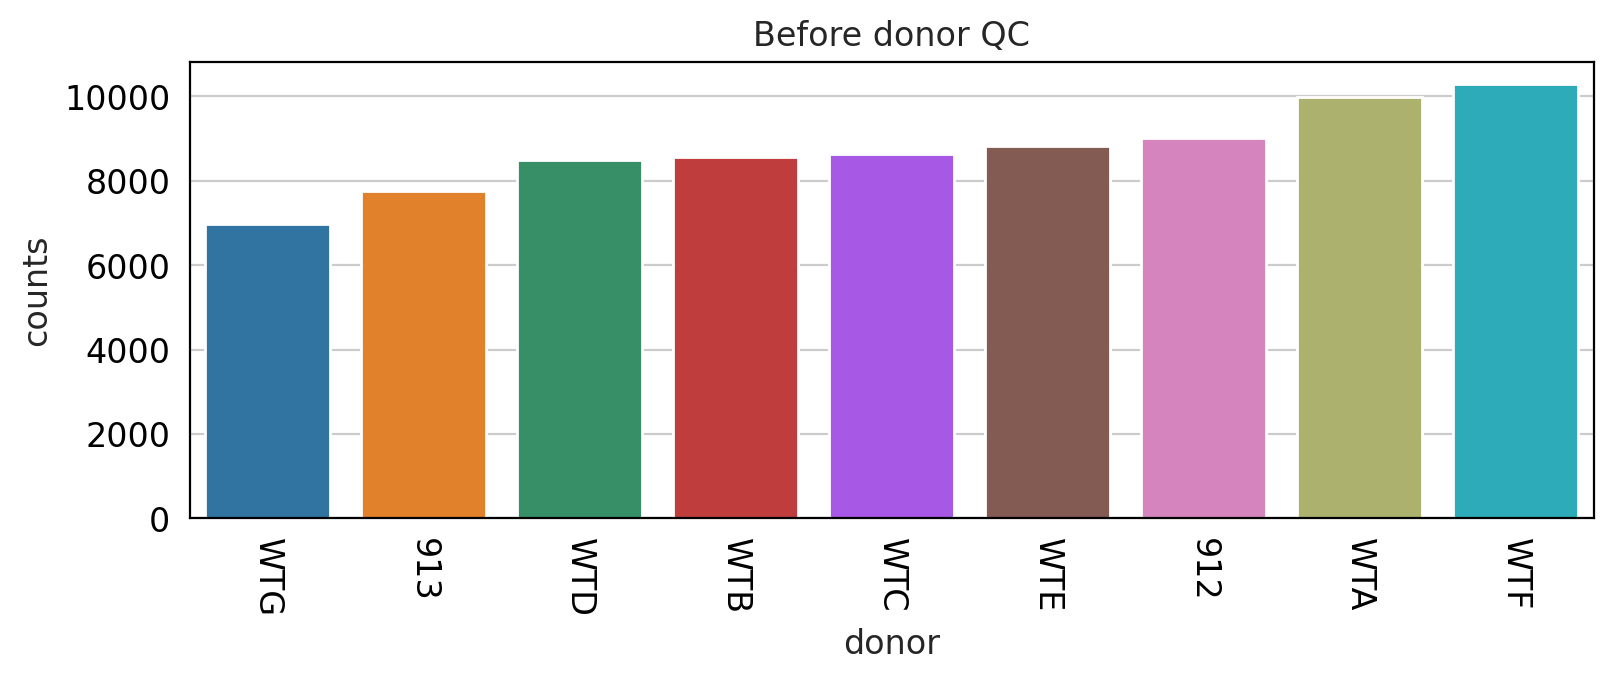

Number of cells before QC: 78565.0
Average number of cells per sample before QC:  8729.4




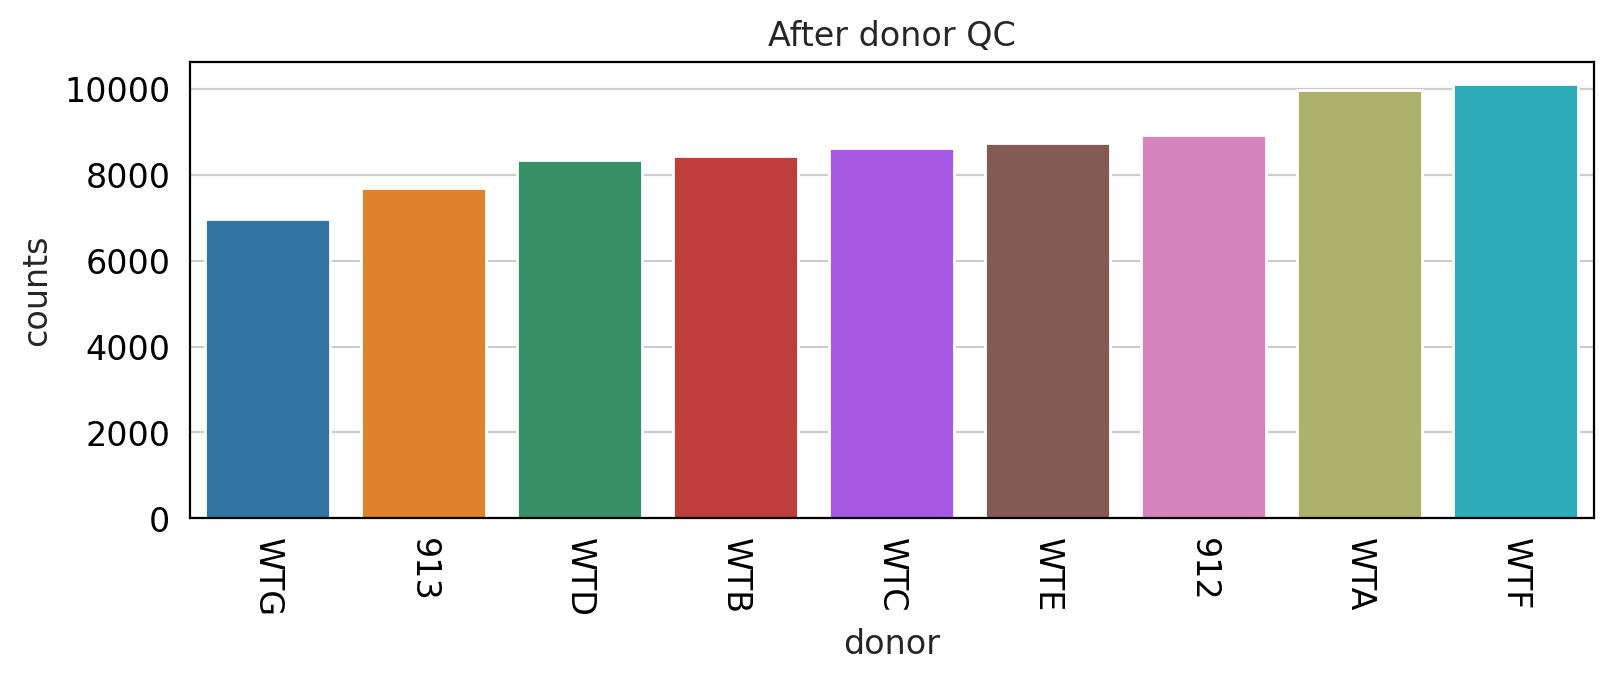

Number of cells after QC: 77833.0
Average number of cells per sample after QC:  8648.1


In [75]:
### before QC
donor_summary = data.obs.donor.value_counts().rename_axis('donor').reset_index(name='counts')


plt.figure(figsize=(9, 3))
sns.barplot(x='donor', y='counts', data=donor_summary[:], order=donor_summary[:].sort_values('counts').donor)
plt.xticks(rotation=-90)
plt.title("Before donor QC")
plt.show()

print(f'Number of cells before QC: {np.sum(donor_summary[donor_summary.counts>0].counts):7.1f}')
print(f'Average number of cells per sample before QC: {np.mean(donor_summary[donor_summary.counts>0].counts):7.1f}')
print()
print()

### after QC
donor_summary = data.obs[data.obs.passed_qc].donor.value_counts().rename_axis('donor').reset_index(name='counts')

plt.figure(figsize=(9, 3))
sns.barplot(x='donor', y='counts', data=donor_summary[:], order=donor_summary[:].sort_values('counts').donor)
plt.xticks(rotation=-90)
plt.title("After donor QC")
plt.show()
print(f'Number of cells after QC: {np.sum(donor_summary[donor_summary.counts>0].counts):7.1f}')
print(f'Average number of cells per sample after QC: {np.mean(donor_summary[donor_summary.counts>0].counts):7.1f}')


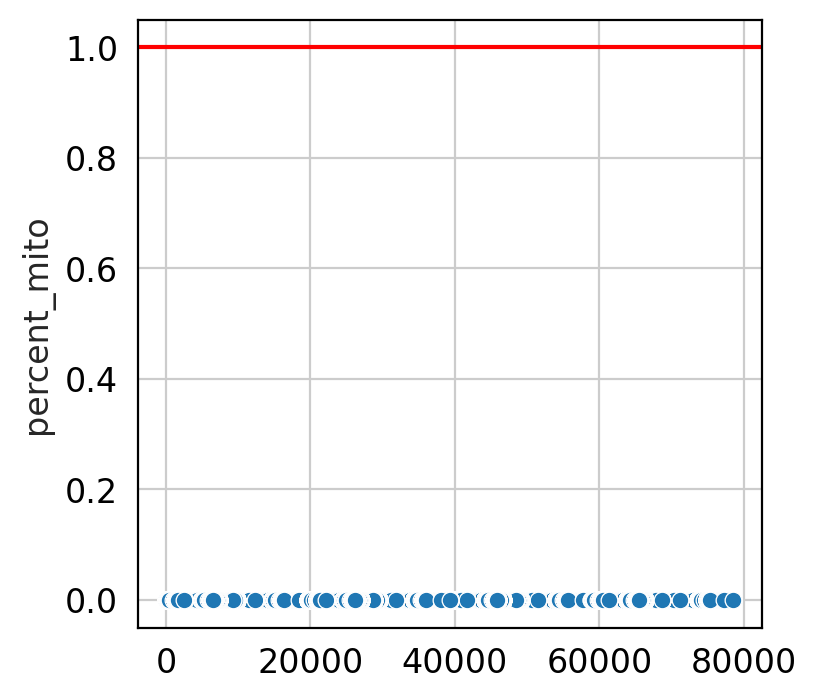

In [76]:
percent_mito = data.obs.percent_mito

temp = percent_mito.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(percent_mito))

sns.scatterplot(x=ranks, y=percent_mito)
plt.axhline(1, color='red')

### Filter the data

In [78]:
### filter donors
pg.filter_data(data)

2023-07-20 11:37:21,587 - pegasusio.qc_utils - INFO - After filtration, 77833 out of 78565 cell barcodes are kept in UnimodalData object GRCm39-rna.
2023-07-20 11:37:21,588 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.61s.


### Log normalize and save the data

In [81]:
pg.log_norm(data)

2023-07-20 11:38:52,862 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 0.89s.


In [82]:
data

MultimodalData object with 1 UnimodalData: 'GRCm39-rna'
    It currently binds to UnimodalData object GRCm39-rna

UnimodalData object with n_obs x n_vars = 77833 x 24058
    UID: GRCm39-rna; Genome: GRCm39; Modality: rna
    It contains 2 matrices: 'counts', 'counts.log_norm'
    It currently binds to matrix 'counts.log_norm' as X

    obs: 'unique_id', 'donor', 'pmi', 'living', 'stage_2_date', 'cdna_amp_cycle', 'input_ng', 'pcr_cycle', 'n_genes', 'n_counts', 'percent_mito', 'Channel', 'scale'
    var: 'gene_name', 'gene_type', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'ribosomal', 'mitochondrial', 'protein_coding', 'robust_protein_coding', 'mitocarta_genes'
    uns: 'genome', 'modality', 'uid', 'norm_count'

In [83]:
fn = os.path.join(save_dir, "mouse_post_qc.h5ad")
data.to_anndata().write(fn, compression='gzip')

/sc/arion/work/massen06/.conda/envs/qc/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
